# Self supervised learning

In [172]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import torchvision.transforms.functional as tf
from PIL import Image

from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset, random_split
from torch.autograd import Variable
from torchvision.models import resnet18
from torchvision.datasets import FashionMNIST, ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage, RandomHorizontalFlip, RandomCrop, ColorJitter, RandomResizedCrop, RandomRotation, \
    RandomAffine, Resize
from matplotlib import pyplot as plt
from random import randint
BATCH_SIZE=64

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
transform = Compose([Resize(32), ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

# FashionMNIST

In [20]:
class FashionMNISTDataset(Dataset):

    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index][0]
        target = self.targets[index][1]

        return data, target

In [300]:
ROOT_DIR = 'fashion_mnist'
TARGET_SIZE = 32
TRANSFORM = Compose([Resize(TARGET_SIZE), ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])
BATCH_SIZE = 256

# Download and load the training data
train_data = FashionMNIST(root=ROOT_DIR, download=True, train=True, transform=transform)
test_data = FashionMNIST(root=ROOT_DIR, download=True, train=False, transform=transform)

In [301]:
def train_val_subset(split):
    """Splits the train data in train and validation subsets."""
    data_set = train_data
    nbr_train_examples = int(len(data_set) * 0.05)
    nbr_val_examples = int(len(data_set) * 0.05)
    nbr_unused_examples = int(len(data_set) * 0.9)
    
    return random_split(data_set, [nbr_train_examples, nbr_val_examples, nbr_unused_examples])

In [302]:
def train_loader_fashion_mnist():
    """Creates the data loader for the train data."""
    train_subset, _, _ = train_val_subset(0.8)

    train_set = FashionMNISTDataset(
        data=train_subset,
        targets=train_subset
    )
    print(len(train_set))

    return DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [303]:
def val_loader_fashion_mnist():
    """Creates the data loader for the validation data."""
    _, val_subset, _ = train_val_subset(0.8)

    val_set = FashionMNISTDataset(
        data=val_subset,
        targets=val_subset
    )
    print(len(val_set))

    return DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

In [304]:
def test_loader_fashion_mnist():
    """Creates the data loader for the test data."""
    return DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [305]:
train_loader = train_loader_fashion_mnist()
val_loader = val_loader_fashion_mnist()
test_loader = test_loader_fashion_mnist()

for xs, ys in train_loader:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in val_loader:
    print(xs.size(), ys.size())
    print(ys)
    break

for xs, ys in test_loader:
    print(xs.size(), ys.size())
    print(ys)
    break        

3000
3000
torch.Size([256, 1, 32, 32]) torch.Size([256])
tensor([9, 8, 3, 5, 1, 6, 6, 1, 4, 5, 2, 9, 5, 6, 7, 5, 8, 4, 7, 8, 2, 7, 9, 1,
        8, 5, 9, 2, 8, 3, 7, 9, 0, 5, 0, 5, 5, 5, 1, 8, 8, 0, 0, 2, 8, 9, 3, 9,
        8, 7, 0, 3, 2, 0, 8, 1, 9, 4, 0, 7, 3, 8, 5, 1, 6, 7, 0, 1, 9, 9, 9, 4,
        5, 9, 9, 4, 3, 1, 6, 9, 4, 7, 6, 8, 5, 0, 5, 0, 9, 5, 7, 3, 5, 8, 3, 2,
        1, 8, 4, 2, 4, 1, 9, 9, 1, 3, 8, 1, 0, 4, 1, 3, 4, 3, 7, 1, 5, 1, 5, 5,
        4, 9, 8, 2, 9, 5, 3, 3, 2, 2, 8, 7, 4, 4, 2, 6, 9, 0, 6, 6, 5, 9, 5, 1,
        9, 4, 4, 1, 6, 8, 3, 2, 7, 4, 4, 0, 0, 7, 7, 2, 4, 0, 0, 4, 1, 3, 6, 0,
        0, 9, 8, 6, 3, 3, 7, 8, 1, 9, 8, 8, 1, 9, 2, 2, 5, 7, 7, 0, 3, 7, 0, 9,
        7, 0, 7, 2, 4, 3, 0, 1, 7, 4, 1, 8, 5, 2, 5, 2, 0, 8, 3, 1, 6, 9, 9, 5,
        9, 4, 1, 2, 9, 8, 6, 9, 2, 1, 6, 8, 1, 3, 1, 1, 1, 5, 0, 8, 4, 3, 8, 8,
        3, 2, 8, 7, 6, 1, 5, 6, 3, 0, 3, 7, 7, 4, 8, 0])
torch.Size([256, 1, 32, 32]) torch.Size([256])
tensor([1, 4, 5, 5, 7, 4, 4, 7, 0, 5, 5

## Rotation

In [196]:
def rotate(image, angle):
    """Rotate the image by the specified angle"""
    image = tf.to_pil_image(image)
    image = tf.rotate(image, angle)
    image = tf.to_tensor(image)
    image = tf.normalize(image, (0.5,), (0.5,))
    return image

torch.Size([512, 1, 32, 32])
torch.Size([512])


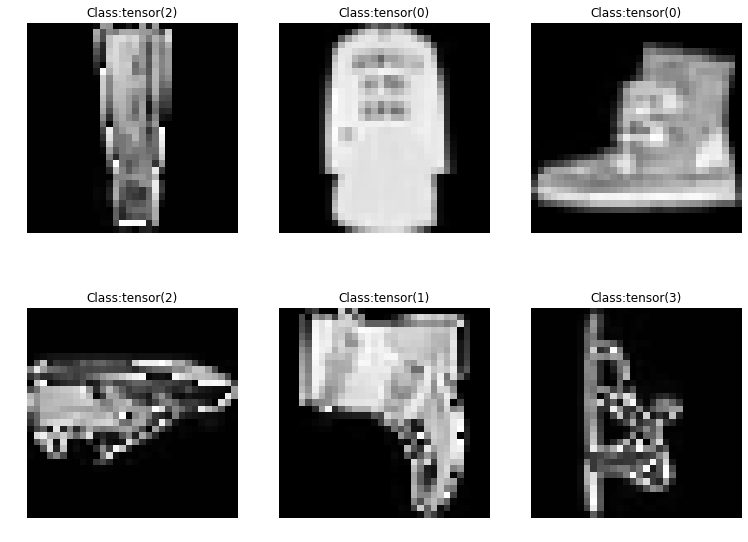

In [197]:
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    images_rotated = []
    labes_rotated = []

    for img in images:
        rotated_imgs = [
            img,
            rotate(img, 90),
            rotate(img, 180),
            rotate(img, 270)
        ]
        rotation_labels = torch.LongTensor([0, 1, 2, 3])
        stack = torch.stack(rotated_imgs, dim=0)

        images_rotated.append(stack)
        labes_rotated.append(rotation_labels)

    images = torch.cat(images_rotated, dim=0)
    labels = torch.cat(labes_rotated, dim=0)
    print(images.shape)
    print(labels.shape)
    
    f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
    axes = [ax for axs in axes for ax in axs]

    for i in range(6):
        index = randint(0, len(images))
        image = images[index]
        label = labels[index]
        axes[i].imshow(image[0].view(32, 32), cmap='gray')
        axes[i].set_title('Class:' + str(label))
        axes[i].axis('off')  
    
    break

## Exemplar CNN

In [306]:
def horizontal_flip(image):
    """Flip image horiontally."""
    transform = Compose([
        RandomHorizontalFlip(p=1.0),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_crop(image):
    """Crop Image."""
    transform = Compose([
        RandomCrop((20, 20)),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def color_jitter(image):
    """Apply color jitter."""
    transform = Compose([
        ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.02),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_resized_crop(image):
    """Randomly resize and crop image."""
    transform = Compose([
        RandomResizedCrop(40, scale=(0.2, 1.0), ratio=(0.75, 1.333)),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_rotation(image):
    """Randomly rotate image."""
    transform = Compose([
        RandomRotation(45),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_affine_transformation(image):
    """Applies a random affine transformation to the image."""
    transform = Compose([
        RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.3), shear=10),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img

In [307]:
def flatten(x):
    """Flattens a tensor."""
    return x.view(x.size(0), -1)


class CifarNet(nn.Module):
    """CifarNet model"""

    def __init__(self, input_channels, num_classes=10):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=(5, 5), bias=False)
        self.max1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.batch1 = nn.BatchNorm2d(num_features=64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(5, 5), bias=False)
        self.batch2 = nn.BatchNorm2d(num_features=64)
        self.max2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.flat = flatten
        self.fc1 = nn.Linear(1600, 384, bias=True)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(384, 192, bias=True)
        self.fc3 = nn.Linear(192, num_classes, bias=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.max1(out)
        out = self.batch1(out)
        out = self.conv2(out)
        out = self.batch2(out)
        out = self.max2(out)
        out = self.flat(out)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [308]:
def transform_image(image, transformation):
    """Randomly transforms one image."""
    transform = ToPILImage()
    img = transform(image.cpu())

    if transformation == 0:
        return horizontal_flip(img)
    if transformation == 1:
        return random_crop(img)
    if transformation == 2:
        return color_jitter(img)
    if transformation == 3:
        return random_resized_crop(img)
    if transformation == 4:
        return random_rotation(img)
    if transformation == 5:
        return random_affine_transformation(img)

In [326]:
def train(model, loss_fn, optimizer, scheduler, num_epochs, train_loader):
    """Train the model"""

    train_losses, train_accuracies = [], []
    best_acc = 0.0
    since = time.time()

    for epoch in range(num_epochs):
        image_index = 0
        scheduler.step()
        model.train()

        running_loss = []
        running_corrects = 0.0
        len_transformed_imgs = 0.0

        for images, labels in train_loader:
            images = images.cpu()
            images_transformed, labes_transformed = [], []

            for index, img in enumerate(images):
                transformed_imgs = [
                    img,
                    transform_image(img, 0),
                    transform_image(img, 1),
                    transform_image(img, 2),
                    transform_image(img, 3),
                    transform_image(img, 4),
                    transform_image(img, 5),
                    transform_image(img, 3),
                    transform_image(img, 4),
                    transform_image(img, 5),
                    transform_image(img, 1),
                    transform_image(img, 3),
                    transform_image(img, 4),
                    transform_image(img, 5),
                    transform_image(img, 3),
                    transform_image(img, 4),
                    transform_image(img, 5),
                    transform_image(img, 3),
                    transform_image(img, 4),
                    transform_image(img, 5)
                ]
                len_transformed_imgs = len(transformed_imgs)
                transformed_labels = torch.LongTensor(np.repeat(image_index, len(transformed_imgs)).tolist())
                stack = torch.stack(transformed_imgs, dim=0)

                images_transformed.append(stack)
                labes_transformed.append(transformed_labels)
                image_index += 1

            images = torch.cat(images_transformed, dim=0).cpu()
            labels = torch.cat(labes_transformed, dim=0).cpu()
            print(labels)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            print(preds)
            loss = loss_fn(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

            # statistics
            running_loss.append(loss.item())
            print(torch.sum(preds == labels.data))
            running_corrects += torch.sum(preds == labels.data).to(torch.float32)

        train_losses.append(np.mean(np.array(running_loss)))
        train_accuracies.append((100.0 * running_corrects) / (len_transformed_imgs * len(train_loader.dataset)))

        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}'.format(
            epoch + 1, num_epochs,
            train_losses[-1],
            train_accuracies[-1]))

    time_elapsed = time.time() - since

    print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best accuracy: {:4f}'.format(best_acc))

In [327]:
train_loader_fashion_mnist = train_loader_fashion_mnist()

TypeError: 'DataLoader' object is not callable

In [328]:
 # number of predicted classes = number of training images

exemplar_cnn = CifarNet(input_channels=1, num_classes=len(train_loader_fashion_mnist.dataset))
exemplar_cnn = exemplar_cnn.cpu()

# Criteria NLLLoss which is recommended with softmax final layer
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(exemplar_cnn.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 4 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.01)

train(exemplar_cnn, loss_fn, optimizer, scheduler, 3, train_loader_fashion_mnist)

tensor([  0,   0,   0,  ..., 255, 255, 255])
tensor([ 416, 2475, 1581,  ...,  736, 2622,  416])
tensor(0)
tensor([256, 256, 256,  ..., 511, 511, 511])
tensor([1501,  688,  688,  ..., 2453, 1017, 2230])
tensor(0)
tensor([512, 512, 512,  ..., 767, 767, 767])
tensor([2005, 1069, 1069,  ..., 2005,   67,  126])
tensor(1)
tensor([ 768,  768,  768,  ..., 1023, 1023, 1023])
tensor([126,  19, 502,  ..., 612, 676, 220])
tensor(0)
tensor([1024, 1024, 1024,  ..., 1279, 1279, 1279])
tensor([1015,   70,  394,  ...,  713,  583,  713])
tensor(0)
tensor([1280, 1280, 1280,  ..., 1535, 1535, 1535])
tensor([2005,  877, 2005,  ..., 1083, 1018, 1002])
tensor(0)
tensor([1536, 1536, 1536,  ..., 1791, 1791, 1791])
tensor([1111, 2005, 2005,  ..., 2005, 1098, 2005])
tensor(0)
tensor([1792, 1792, 1792,  ..., 2047, 2047, 2047])
tensor([ 203, 1158, 1532,  ..., 1486, 1486, 1713])
tensor(0)
tensor([2048, 2048, 2048,  ..., 2303, 2303, 2303])
tensor([1767, 1550, 1509,  ..., 1612, 1612, 1625])
tensor(0)
tensor([2304, 23

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /Users/soumith/b101_2/2019_02_08/wheel_build_dirs/wheel_3.6/pytorch/aten/src/THNN/generic/ClassNLLCriterion.c:93

In [217]:
f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
    axes = [ax for axs in axes for ax in axs]

    for i in range(6):
        index = randint(0, len(images))
        image = images[index]
        label = labels[index]
        axes[i].imshow(image[0].view(32, 32), cmap='gray')
        axes[i].set_title('Class:' + str(label))
        axes[i].axis('off')  
    
    break

IndentationError: unexpected indent (<ipython-input-217-5711a111f140>, line 2)

## DeepFashion

In [173]:
ROOT_DIR = '../img/'
TARGET_SIZE = (32, 32)
BATCH_SIZE = 64

TRANSFORM_DEEP_FASHION = Compose([Resize(TARGET_SIZE), ToTensor(), Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
ROOT_DIR_DEEP_FASHION = '../'

In [174]:
def default_loader(path):
    return Image.open(path)

In [175]:
class DeepFashionDataset(Dataset):
    """Creates the DeepFashion data set."""
    def __init__(self, root, image_list, targets, transform=TRANSFORM_DEEP_FASHION, loader=default_loader):
        self.root = root
        self.image_list = image_list
        self.targets = targets
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        try:
            image_path = self.image_list[index]
            img = self.loader(os.path.join(self.root, image_path))
            target = self.targets[index]
            if self.transform is not None:
                img = self.transform(img)
            return img, target
        except IndexError:
            print('do nothing')

    def __len__(self):
        return len(self.image_list)

In [176]:
def load_list_category_img():
    """Load the list containing the image name and the associated category."""
    list_category_img = pd.read_csv('../list_category_img.txt', sep="\t", header=0)
    list_category_img.columns = ["image_name", "category_label"]
    return list_category_img


In [177]:
def load_list_category_cloth():
    """Load the list containing the category name and the associated category type."""
    list_category_cloth = pd.read_csv('../list_category_cloth.txt', sep="\t", header=0)
    list_category_cloth.columns = ["category_name", "category_type"]
    return list_category_cloth


In [178]:
def load_list_eval_partition():
    """Load the list containing the image name and the associated evaluation status."""
    list_eval_partition = pd.read_csv('../list_eval_partition.txt', sep="\t", header=0)
    list_eval_partition.columns = ["image_name", "evaluation_status"]
    return list_eval_partition

In [179]:
def train_data():
    """Return the images with the evaluation status 'train'."""
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    result = partition[partition.evaluation_status == 'train']
    result = result.sample(60000)
    train_indices = result.index

    list_train_images = result.image_name.values
    train_labels = labels.category_label[train_indices].values

    return DeepFashionDataset(root=ROOT_DIR_DEEP_FASHION, image_list=list_train_images, targets=train_labels)

In [180]:
def val_data():
    """Return the images with the evaluation status 'val'."""
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    result = partition[partition.evaluation_status == 'val']
    result = result.sample(20000)
    val_indices = result.index

    list_val_images = result.image_name.values
    val_labels = labels.category_label[val_indices].values

    return DeepFashionDataset(root=ROOT_DIR_DEEP_FASHION, image_list=list_val_images, targets=val_labels)

In [181]:
def test_data():
    """Return the images with the evaluation status 'test'."""
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    result = partition[partition.evaluation_status == 'test']
    result = result.sample(20000)
    test_indices = result.index

    list_test_images = result.image_name.values
    test_labels = labels.category_label[test_indices].values

    return DeepFashionDataset(root=ROOT_DIR_DEEP_FASHION, image_list=list_test_images, targets=test_labels)

In [182]:
def train_loader_deep_fashion():
    """Return the data loader for the train data."""
    return DataLoader(train_data(), batch_size=BATCH_SIZE, shuffle=False)


def val_loader_deep_fashion():
    """Return the data loader for the validation data."""
    return DataLoader(val_data(), batch_size=BATCH_SIZE, shuffle=False)


def test_loader_deep_fashion():
    """Return the data loader for the test data."""
    return DataLoader(test_data(), batch_size=BATCH_SIZE, shuffle=False)

In [183]:
train_loader = train_loader_deep_fashion()

for xs, ys in train_loader:
    print(xs.size(), ys.size())
    print(ys) 
    break

torch.Size([64, 3, 32, 32]) torch.Size([64])
tensor([19,  3, 41, 32, 41, 26, 41, 16, 41, 31, 48, 33, 19, 19, 41,  3, 17, 26,
        41, 41, 30, 41, 26,  6, 41, 41, 39, 33, 12, 41, 41, 17,  3,  3, 41, 16,
        35, 33, 18, 41, 41, 29, 41, 41, 18, 32, 41, 33,  3, 13, 18, 41, 41, 18,
        42,  2, 18, 32,  6,  3, 18,  6,  6, 18])


In [190]:
def rotate(image, angle):
    """Rotate the image by the specified angle"""
    
    image = tf.to_pil_image(image)
    image = tf.rotate(image, angle)
    image = tf.to_tensor(image)
    if image.shape[0] == 3:
        image = tf.normalize(image, (0.5,0.5,0.5,), (0.5,0.5,0.5,))
    else:
        image = tf.normalize(image, (0.5,), (0.5,))
    return image

In [130]:
for images, labels in train_loader_deep_fashion_test():
    images = images
    labels = labels

    print(images.shape)
    print(labels.shape)
    
    images_rotated = []
    labes_rotated = []
    
    for index, img in enumerate(images):
        rotated_imgs = [
            img,
            rotate(img, 90),
            rotate(img, 180),
            rotate(img, 270)
        ]
        rotation_labels = torch.LongTensor([0, 1, 2, 3])
        stack = torch.stack(rotated_imgs, dim=0)

        images_rotated.append(stack)
        labes_rotated.append(rotation_labels)

    images = torch.cat(images_rotated, dim=0)
    labels = torch.cat(labes_rotated, dim=0)
    print(labels)
    print(images.shape)
    print(labels.shape)
    break

do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing
do nothing

TypeError: batch must contain tensors, numbers, dicts or lists; found <class 'NoneType'>